In [134]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Exploratory Data Analysis and Model Building

In [135]:
df = pd.read_csv('static/2023_APR.csv', index_col=0)
df.head()

,resale_price,year,month,timeseries_month,region,town,rooms,avg_storey,floor_area_sqm,remaining_lease,dist_to_station,min_pt_time
150072,298000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,2.0,8.0,44.0,53.750000,498.0,213.0
150073,305000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,2.0,8.0,44.0,56.166667,463.0,306.0
150074,372000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,3.0,2.0,82.0,53.333333,1150.0,523.0
150075,585000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,3.0,20.0,70.0,88.416667,1102.0,409.0
150076,350000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,3.0,5.0,68.0,56.833333,1201.0,500.0


## 1. EDA
### Summary of actions before training

1. Handling null values and Checking for collinearity
2. Preprocessing (mean encoding)
3. Feature selection (KBest, Lasso regression)
4. Model selection
5. Hyperparameter tuning 

### 1.1 Handling null values

In [136]:
display(df[df['dist_to_station'].isna()])
df.dropna(inplace=True)

,resale_price,year,month,timeseries_month,region,town,rooms,avg_storey,floor_area_sqm,remaining_lease,dist_to_station,min_pt_time
151094,1010000.0,2023,4,2023-04-01,Central,Kallang/Whampoa,4.0,26.0,95.0,86.833333,NaN,NaN
151206,343000.0,2023,4,2023-04-01,North-East,Punggol,2.0,14.0,48.0,94.833333,NaN,NaN
151207,350000.0,2023,4,2023-04-01,North-East,Punggol,2.0,14.0,47.0,94.666667,NaN,NaN
151209,348000.0,2023,4,2023-04-01,North-East,Punggol,2.0,5.0,38.0,94.583333,NaN,NaN
151229,460000.0,2023,4,2023-04-01,North-East,Punggol,3.0,11.0,68.0,94.666667,NaN,NaN
151313,565000.0,2023,4,2023-04-01,North-East,Punggol,4.0,11.0,93.0,94.666667,NaN,NaN
151317,585000.0,2023,4,2023-04-01,North-East,Punggol,4.0,11.0,93.0,94.666667,NaN,NaN
151318,530000.0,2023,4,2023-04-01,North-East,Punggol,4.0,2.0,93.0,94.666667,NaN,NaN
151319,550000.0,2023,4,2023-04-01,North-East,Punggol,4.0,11.0,93.0,94.666667,NaN,NaN
151322,554000.0,2023,4,2023-04-01,North-East,Punggol,4.0,8.0,93.0,94.583333,NaN,NaN


In [137]:
display(df.isna().sum())

resale_price        0
year                0
month               0
timeseries_month    0
region              0
town                0
rooms               0
avg_storey          0
floor_area_sqm      0
remaining_lease     0
dist_to_station     0
min_pt_time         0
dtype: int64

### Explanation for each feature

| Feature           | Explanation                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| resale_price      | Dependent variable, the selling price of the flat                                               |
| floor_area_sqm    | Total floor area (in square meters) of the flat                                                 |
| remaining_lease   | Remaining lease of the flat in months                                                           |
| rooms             | Number of rooms in the flat (whole numbers except for 4.5, which represents an executive flat with an extra study/balcony) |
| avg_storey        | Mean value of the floor range (intervals of 3 storeys)                                          |
| dist_to_station   | Distance in meters to the nearest MRT (Mass Rapid Transit) station                              |
| min_pt_time       | Time in seconds to reach the nearest MRT station by public transport and walking                |


### 1.1 Checking for collinearity among numerical features
* There is strong collinearity between 
    * floor_area_sqm and rooms (0.86)
    * dist_to_station and min_pt_time (0.69)
* Even much so higher than their correlation with output (resale price)
* For linear models, we need to remove one of each pair of feature to ensure that there is no multicollinearity, for this I will remove the feature with lower Pearson's correlation with our output
    * rooms (0.65)
    * min_pt_time (0.69)

<Axes: >

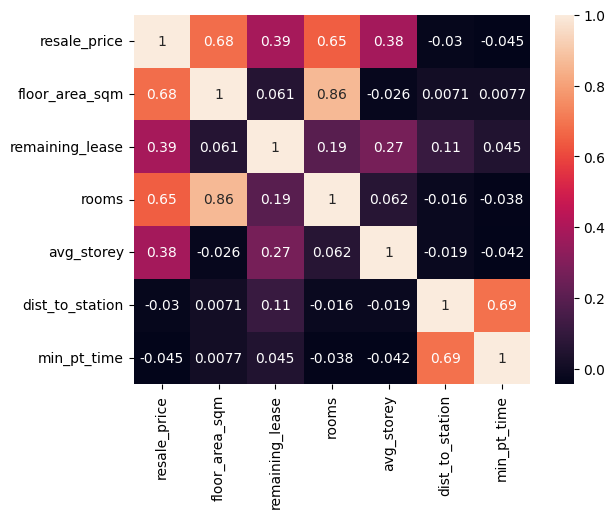

In [138]:
impt_features = df[['resale_price', 'floor_area_sqm', 'remaining_lease', 'rooms', 'avg_storey', 'dist_to_station', 'min_pt_time']]
sns.heatmap(impt_features.corr(), annot=True)

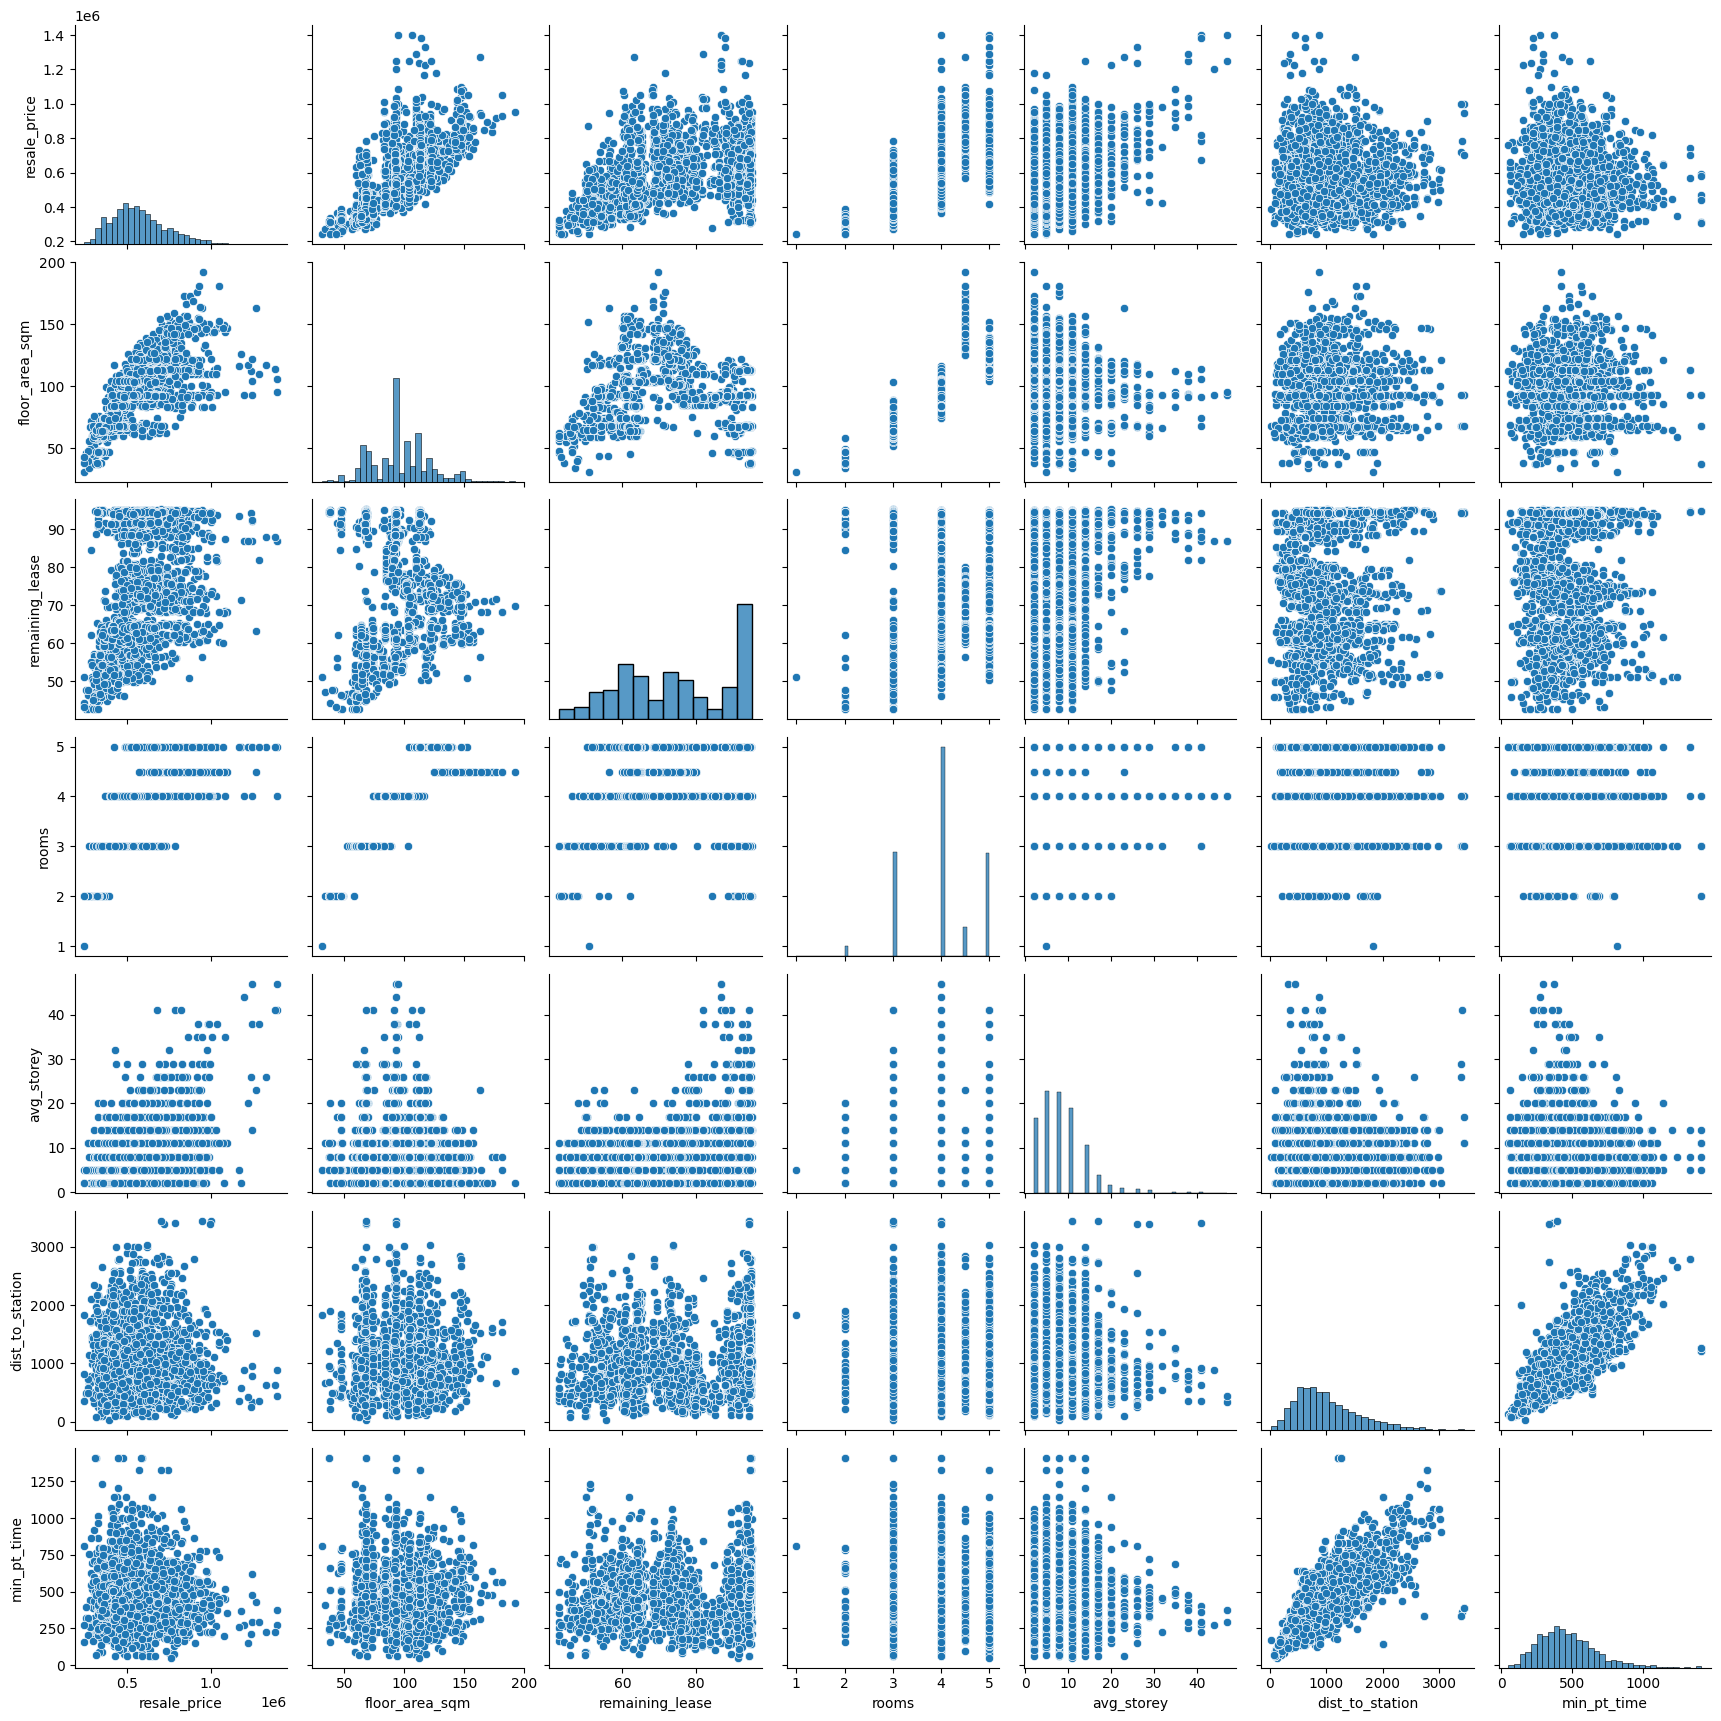

In [139]:
sns.pairplot(impt_features)
plt.show()

#### What are the most expensive neighbourhoods?

Each neighbourhood has a different mean price due to a non-exhaustive number of factors:

* location
* infrastructure and amenitites
* affluent / less affluent neighbourhoods
* supply and demand
* market speculation  

In [140]:
town_prices = df.groupby(['town', 'rooms'])[['resale_price']].mean(numeric_only=True).sort_values(by=['town','rooms'], ascending=False)
town_prices.unstack().style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

### 1.2 Preprocessing (mean encoding)
* I will perform mean encoding (resale_price) onto the town and rooms.
* Take note that mean encoding may sometimes result in overfitting.

In [141]:
def columns_to_tuple(df):
    '''
    Function to combined town and rooms as a tuple for dictionary mapping
    '''
    return (df['town'],  df['rooms'])

# Get the dictionary of the town and rooms for mean encoding
town_mean_dict = df.groupby(['town', 'rooms'])['resale_price'].mean(numeric_only=True).to_dict()
town_tuple = df.apply(columns_to_tuple, axis=1)
town_tuple.name = 'mean_price_by_town_rooms'

# Encode through mapping
town_mean_price = town_tuple.map(town_mean_dict)
df = pd.concat([impt_features, town_mean_price], axis =1)
df.head()


,resale_price,floor_area_sqm,remaining_lease,rooms,avg_storey,dist_to_station,min_pt_time,mean_price_by_town_rooms
150072,298000.0,44.0,53.750000,2.0,8.0,498.0,213.0,301500.0
150073,305000.0,44.0,56.166667,2.0,8.0,463.0,306.0,301500.0
150074,372000.0,82.0,53.333333,3.0,2.0,1150.0,523.0,406272.0
150075,585000.0,70.0,88.416667,3.0,20.0,1102.0,409.0,406272.0
150076,350000.0,68.0,56.833333,3.0,5.0,1201.0,500.0,406272.0


In [174]:
# Try label encoding the town by most exp to least?

### 1.3 Feature selection

In [146]:
X_unscaled = df.iloc[:,1:]
y = df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SelectKBest using Mutual Information

In [147]:
X_df = pd.DataFrame(X, columns=X_unscaled.columns)
kbest = SelectKBest(score_func=mutual_info_regression, k='all')
kbest.fit(X_df, y)
pd.DataFrame(kbest.scores_, index=kbest.get_feature_names_out(kbest.feature_names_in_), columns=['Mutual Info Score'])

,Mutual Info Score
floor_area_sqm,0.742771
remaining_lease,0.251090
rooms,0.525731
avg_storey,0.117872
dist_to_station,0.046948
min_pt_time,0.052686
mean_price_by_town_rooms,0.859172


Lasso regularisation to determine less important features

In [150]:
# LassoCV here uses crossvalidation to determine the optimum alpha (penalty value)
lr_reg1 = LassoCV(random_state=42)
lr_reg1.fit(X_train, y_train)
r2 = r2_score(y_test, lr_reg1.predict(X_test))
print(f'R2 score: \t{np.round(r2,3)}')
print(f'Selected Alpha: {np.round(lr_reg1.alpha_,3)}')
print(f'Bias: \t\t{np.round(lr_reg1.intercept_,3)}')
display(pd.DataFrame(lr_reg1.coef_, index=X_unscaled.columns, columns=['Features']))

R2 score: 	0.855
Selected Alpha: 33.317
Bias: 		172545.518


,Features
floor_area_sqm,365552.131469
remaining_lease,155482.550223
rooms,-193195.362796
avg_storey,265403.044638
dist_to_station,6973.283370
min_pt_time,-37997.705634
mean_price_by_town_rooms,695533.437343


#### Final selection of features

Based on all the investigation done so far, the following features will be excluded:
* rooms
* dist_to_station

In [157]:
X_unscaled = df[['floor_area_sqm', 'remaining_lease', 'avg_storey', 'min_pt_time', 'mean_price_by_town_rooms']]
y = df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Model Selection
We will compare the following models in general, before hyperparameter tuning
* SGD Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

In [158]:
models = [SGDRegressor(random_state=42), 
          LassoCV(random_state=42),
          RandomForestRegressor(random_state=42), 
          GradientBoostingRegressor(random_state=42)]

for model in models:
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    print(f'R2 score for {model}: {np.round(r2,3)}')

R2 score for SGDRegressor(random_state=42): 0.841
R2 score for LassoCV(random_state=42): 0.845
R2 score for RandomForestRegressor(random_state=42): 0.904
R2 score for GradientBoostingRegressor(random_state=42): 0.876


In [173]:
for model in models[2:]:
    display(pd.DataFrame(model.feature_importances_, index=X_unscaled.columns, columns=[f'Feature importances for {model}']))

,Feature importances for RandomForestRegressor(random_state=42)
floor_area_sqm,0.162350
remaining_lease,0.122980
avg_storey,0.054182
min_pt_time,0.027340
mean_price_by_town_rooms,0.633148


,Feature importances for GradientBoostingRegressor(random_state=42)
floor_area_sqm,0.082596
remaining_lease,0.141702
avg_storey,0.055430
min_pt_time,0.011780
mean_price_by_town_rooms,0.708492


### 1.5 Hyperparameter tuning
I will perform randomCV